He limpiado más los datos y he probado distintas combinaciones de modelos, cogiendo menos valores y también al final creando algunos sintéticos.

Algunas de las funciones que uso están utils, también puedes cogerlas y ejecutarlas desde aquí, pero queda más limpio tenerlas todas en otro lado y solo llamarlas.

In [2]:
import os
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# New imports
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load("en_core_web_md")

from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from src.utils import *    # Aquí llamas a las funciones que luego uso aquí. Src significa source y ahi metes funciones (utils), constantes (contants)...
from src.constants import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk
from nltk.corpus import stopwords
# Descargar stopwords en español
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


### 1) Limpieza de Feli

In [4]:
df = pd.read_csv('dataCCDD.csv', sep=';', encoding='utf-8') 

In [5]:
# Cargar el archivo CSV
# Le indicamos como estan separados los datos
# Como los datos son texto le indicamos utf-8

def preprocesar_texto(texto):
    # Eliminar tildes y normalizar texto
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    # Convertir a minúsculas y eliminar stopwords
    palabras = texto.lower().split()
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    return ' '.join(palabras)

In [6]:
company_stopwords

{'co',
 'corp',
 'corporation',
 'gmbh',
 'inc',
 'limited',
 'llc',
 'ltd',
 'sa',
 'sarl'}

#### Improved cleaned function, with extra cleaning processes

He cambiado bastante la tienes en utils bien explicada. He aplicado cosas específicas para este texto en concreto además de cosas generales para estandarizarlo y dejarlo con el mismo formato

In [18]:
# Function to apply cleaning to selected text columns in a DataFrame
def apply_text_cleaning(df, text_columns):
    """ Applies the cleaning function to specified text columns in a DataFrame and keeps all original columns """
    for col in text_columns:
        df[f"{col}_clean"] = df[col].apply(lambda x: clean_text(x)[0])  # Lemmatized with stopwords
        df[f"{col}_lem_no_stopwords"] = df[col].apply(lambda x: clean_text(x)[1])  # Lemmatized without stopwords
        df[f"{col}_stem_no_stopwords"] = df[col].apply(lambda x: clean_text(x)[2])  # Stemmed without stopwords
    return df

In [9]:
# Aplicar preprocesamiento a las columnas de texto
df['TextoCombinado'] = df['Purchase document description'] + ' ' + df['Company Name']
df['TextoCombinado'] = df['TextoCombinado'].apply(preprocesar_texto)

df_cleaned = apply_text_cleaning(df, ['TextoCombinado'])

In [10]:
df_cleaned.head(3)

,Purchase document description,Company Name,MG Code,TextoCombinado,TextoCombinado_clean,TextoCombinado_lem_no_stopwords,TextoCombinado_stem_no_stopwords
0,PROGRAMAS DE FORMACIÓN COMERCIAL,"LIFE SKILS, SL",SPFO01,"programas formacion comercial life skils, sl",programas formacion comercial life skils sl,programas formacion comercial life skils sl,programa formacion comerci life skil sl
1,"RP PARA PLANTA SOLAR FV 11,477 MWP KRONOSPAN-B...","NOVOTEC CONSULTORES, S.A.",SPPT44,"rp planta solar fv 11,477 mwp kronospan-burgos...",rp planta solar fv 11477 mwp kronospanburgos n...,rp planta solar fv 11477 mwp kronospanburgos n...,rp planta solar fv 11477 mwp kronospanburgo no...
2,"""SERVICIO DE APOYO INGENIERÍA CT FOIX (CUBELLES)”","APPLUS NORCONTROL, S.L.U",SPPT10,"""servicio apoyo ingenieria ct foix (cubelles)”...",servicio apoyo ingenieria ct foix cubelles app...,servicio apoyo ingenieria ct foix cubelles app...,servicio apoyo ingenieria ct foix cubel applu ...


In [11]:
df_cleaned['Company Name'].value_counts()

Company Name
ELEKTRA ANDALUCIA XXI S.L              40
TRANSERON, S.L.                        36
AMIDATA, S.A.                          34
BLACKOUTIBERICA S.L.                   32
M.CASERO, S.A.                         27
                                       ..
ORION SERV.OFICINA E INFORMATICA,SL     1
MDA SERVICES                            1
BBA 1 INTERNATIONAL ENGINEERING SL      1
INAUTA IMPORT-EXPORT S.L.               1
DIARIO CORDOBA, S.A.                    1
Name: count, Length: 703, dtype: int64

In [12]:
df_cleaned['MG Code'].value_counts()  # Hay 290 códigos distintos, algunos sólo con 1 registro

MG Code
FEMI04    180
FZAU10     92
FOCU02     68
FZAU21     65
SPCN06     65
         ... 
FZDS05      1
FLMA03      1
FCLU02      1
SPAB01      1
FELC16      1
Name: count, Length: 290, dtype: int64

In [13]:
set(df_cleaned['TextoCombinado'])  # See how are the texts

{'gazelec 2024 spex - sponsoring fva 2024-768 content and business',
 'material electrico reposicion almacen central cas tresorer elektra andalucia xxi s.l',
 'pinnza amperimetrica, mto.electrico sstt_uph-no. amidata, s.a.',
 'pago almacenamiento trafo plan ax.02329 - binefar 110/2 industrias mecanoelectricas fontecha yebenes, s.l.',
 'material contraincendios proteccion automatica incendios, s.a.',
 'servicio lineas internet 02/24 fva 2024-712 sfr business',
 '4 tacos impresos autorizacion salid publicidade dixital galega, s.l.',
 'analizador s02 central alcudia dnota medio ambiente, s.l.',
 'suministro material industrial segun alb 0.417347 - tplb materiales gases industriales, sl',
 'ad material analizador cems (ipu) sick optic-electronic, s.a.u',
 'anuidade selo electronico qualificado digitalsign - certificadora digital',
 'asistencia tecnica precintado 3 valvulas - tp barrios sgs inspecciones reglamentarias, s.a. (unipersonal)',
 'medicion desalineamiento relativo angulo pala_sie

### 2) Training

#### 2.1) Simple training

Los funciones para entrenar están utils, básicamente tienes el vectorizador que transforma cada fila en un vector, tan grande como el número de palabras que hay (el vocabulario). Usa TFIDF, así que el vector sólo depende de las veces que aparecen las palabras en una determinada fila y en el conjunto de todos los datos.

El clasificador es una regresión logística, es un modelo simple, pero que en este caso funciona bastante bien, simplemente va cogiendo distintos puntos, midiendo cómo de lejos están de los valores reales y usando el gradiente para encontrar el nuevo punto (mira un vídeo o algo así). Tiene distintas parámetros con los que en este ejemplo pruebo.

In [14]:
X = df_cleaned['TextoCombinado_lem_no_stopwords']
y = df_cleaned['MG Code']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
tfidf_grid={'max_features': [5000, 10000, 20000], 'min_df': [5, 10, 20], 'max_df': [0.5, 0.7, 1.0], 'ngram_range': [(1, 1), (1, 2)]}
best_vectorizer, X_train_tfidf, X_val_tfidf, best_params = tfidf_params(X_train, X_val, y_train, y_val, tfidf_grid)

Best TF-IDF params: {'max_df': 0.5, 'max_features': 5000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.31723919905344056


In [16]:
model_grid = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model, best_params_logreg = train_logistic_regression(X_train_tfidf, y_train, model_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


(accuracy, f1) are: (0.452632, 0.414894)

Classification Report:
               precision    recall  f1-score   support

      FAAI02       0.00      0.00      0.00         1
      FAAI06       0.00      0.00      0.00         0
      FCCC04       0.00      0.00      0.00         1
      FCCU01       0.00      0.00      0.00         0
      FCCU10       0.00      0.00      0.00         2
      FCMC03       0.00      0.00      0.00         1
      FCMS01       0.00      0.00      0.00         1
      FCMS08       0.60      1.00      0.75         3
      FEER08       0.75      0.60      0.67         5
      FEIN08       0.00      0.00      0.00         1
      FEIT15       0.00      0.00      0.00         0
      FEME07       0.00      0.00      0.00         2
      FEMI04       0.29      0.67      0.41        15
      FEQE29       0.00      0.00      0.00         1
      FETR05       1.00      1.00      1.00         1
      FHIC06       0.00      0.00      0.00         0
      FHIC08   

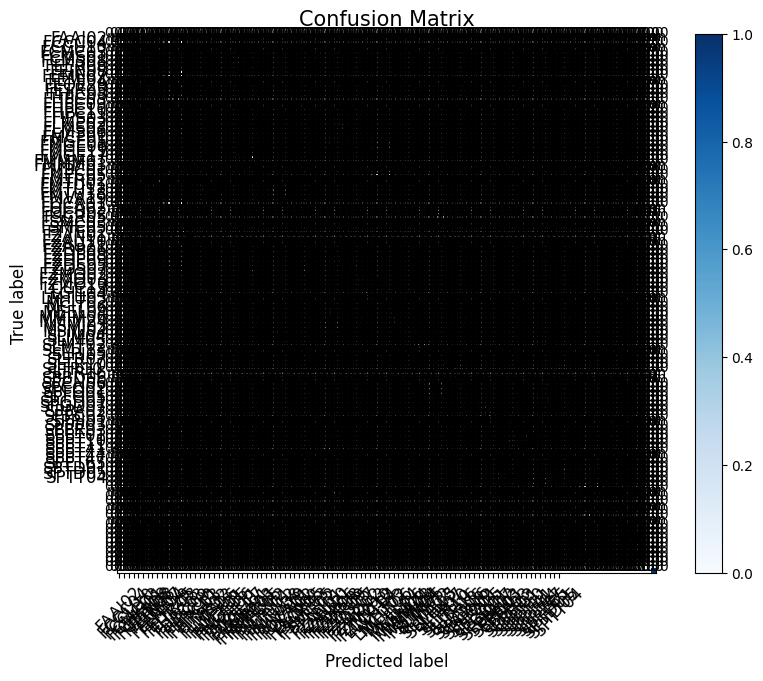

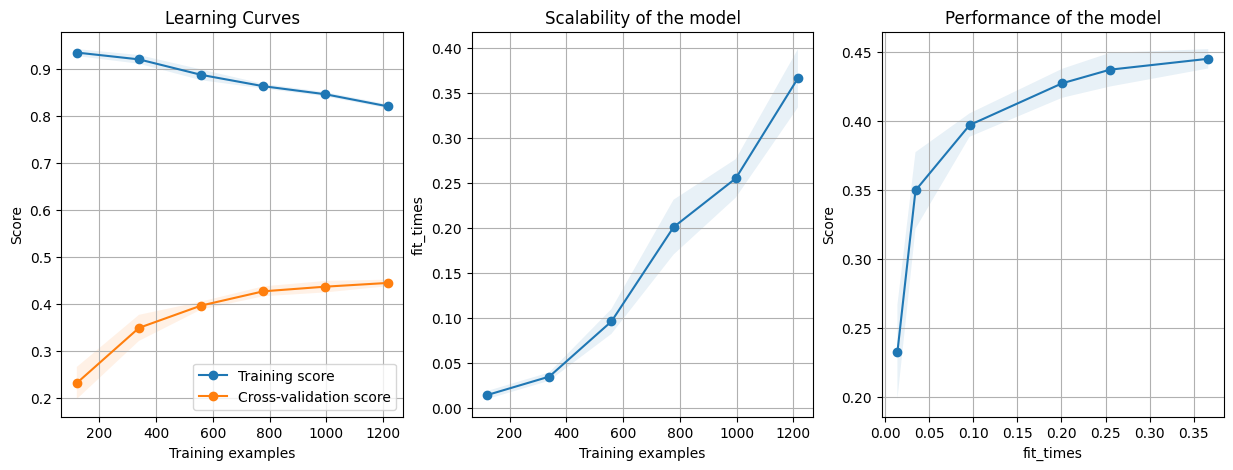

In [17]:
X_test_tfidf = best_vectorizer.transform(X_test)
y_test_pred = best_model.predict(X_test_tfidf)
evaluate_model_new(X_train_tfidf, y_train, y_test, y_test_pred, best_model)

Muchísimas categorías=malos resultados en general

#### 2.2) Just using the 10 most common categories

In [79]:
df_cleaned['MG Code'].value_counts().head(15)

MG Code
FEMI04    180
FZAU10     92
FOCU02     68
FZAU21     65
SPCN06     65
FOCA02     50
FMCF01     47
SPPT10     40
FEER08     37
SPPP03     36
SLMT13     35
SLTR10     31
SPPT22     27
FHPC09     25
SPPI01     24
Name: count, dtype: int64

In [85]:
# Step 1: Count MG Code frequencies
mg_counts = df_cleaned["MG Code"].value_counts()

# Step 2: Select only MG categories that have at least a minimum number of occurrences
min_samples_per_category = 35  # Set a threshold
top_mg_codes = mg_counts[mg_counts >= min_samples_per_category].index.tolist()

# Step 3: Filter dataset to include only rows with selected MG Codes
df_filtered = df_cleaned[df_cleaned["MG Code"].isin(top_mg_codes)]

In [86]:
X_filt = df_filtered['TextoCombinado_lem_no_stopwords']
y_filt = df_filtered['MG Code']

X_train_filt, X_temp_filt, y_train_filt, y_temp_filt = train_test_split(X_filt, y_filt, test_size=0.2, random_state=42)
X_val_filt, X_test_filt, y_val_filt, y_test_filt = train_test_split(X_temp_filt, y_temp_filt, test_size=0.5, random_state=42)

In [87]:
best_vectorizer_filt, X_train_tfidf_filt, X_val_tfidf_filt, best_params_filt = tfidf_params(X_train_filt, X_val_filt, y_train_filt, y_val_filt, tfidf_grid)

Best TF-IDF params: {'max_df': 0.5, 'max_features': 5000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.7455625185921859


In [88]:
best_model_filt, best_params_logreg_filt = train_logistic_regression(X_train_tfidf_filt, y_train_filt, model_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


(accuracy, f1) are: (0.805556, 0.807109)

Classification Report:
               precision    recall  f1-score   support

      FEER08       0.75      0.60      0.67         5
      FEMI04       0.74      0.89      0.81        19
      FMCF01       1.00      0.67      0.80         6
      FOCA02       0.25      0.33      0.29         3
      FOCU02       1.00      0.89      0.94         9
      FZAU10       0.62      0.83      0.71         6
      FZAU21       1.00      1.00      1.00         6
      SLMT13       1.00      1.00      1.00         4
      SPCN06       0.80      1.00      0.89         4
      SPPP03       1.00      0.75      0.86         4
      SPPT10       1.00      0.50      0.67         6

    accuracy                           0.81        72
   macro avg       0.83      0.77      0.78        72
weighted avg       0.84      0.81      0.81        72



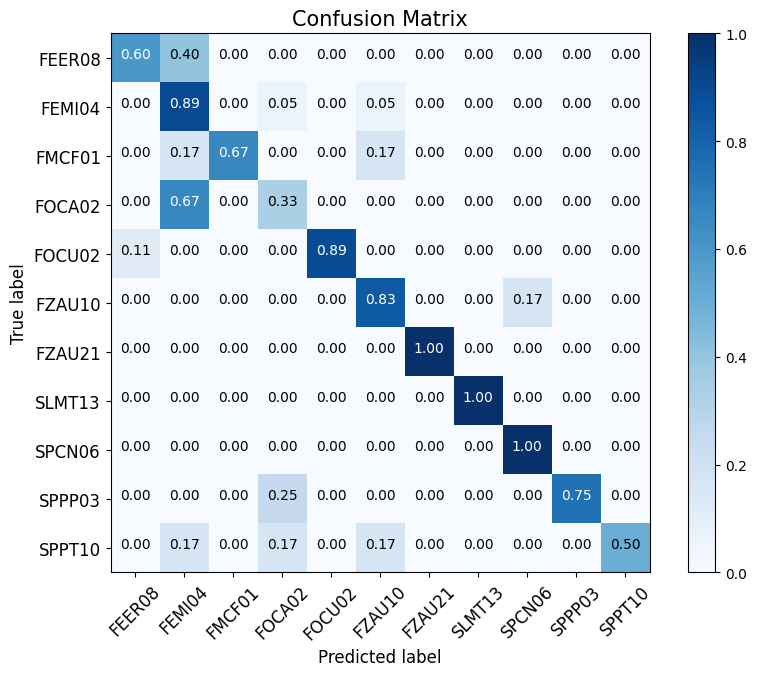

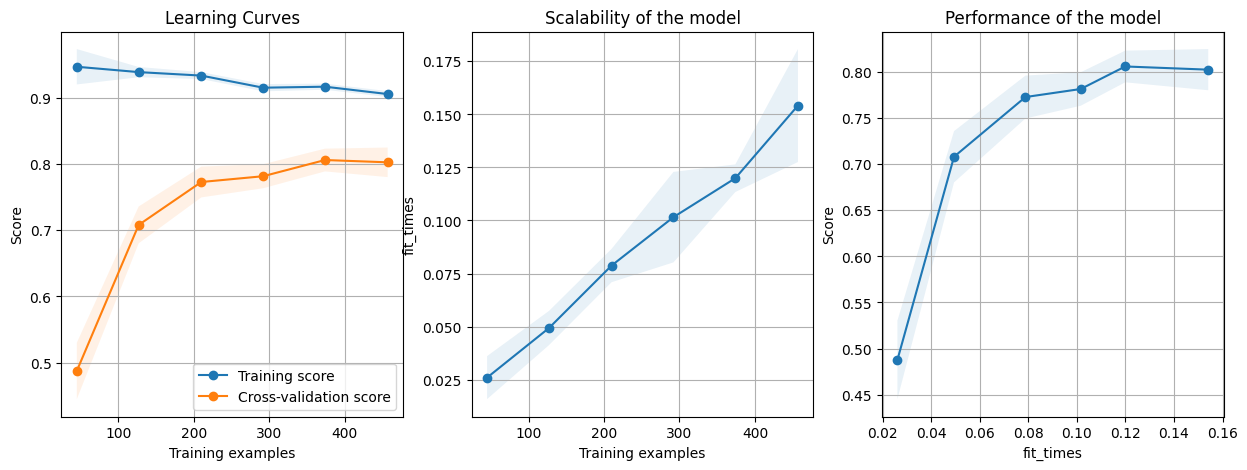

In [89]:
X_test_tfidf_filt = best_vectorizer_filt.transform(X_test_filt)
y_test_pred_filt = best_model_filt.predict(X_test_tfidf_filt)
evaluate_model_new(X_train_tfidf_filt, y_train_filt, y_test_filt, y_test_pred_filt, best_model_filt)

(accuracy, f1) are: (0.805556, 0.807109)  For top 10                               
(accuracy, f1) are: (0.720430, 0.718877) For top 20


#### 2.3) With Embeddings

tfidf just takes into account the number of times a word appears in one record compared to the number of times it appears in total. It doesn't understand at all the meaning of the context, it just gives a score based on the times the term appears

Embeddings in another way of vectorizing text, the one used by LLMs (like ChatGPT) that does take into account the meaning of the words and also the context and its values are more difficult to explain, there is no exact calculus behind them.

In [22]:
model_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [105]:
df_filtered.head()

,Purchase document description,Company Name,MG Code,TextoCombinado,TextoCombinado_clean,TextoCombinado_lem_no_stopwords,TextoCombinado_stem_no_stopwords
0,"""SERVICIO DE APOYO INGENIERÍA CT FOIX (CUBELLES)”","APPLUS NORCONTROL, S.L.U",SPPT10,"""servicio apoyo ingenieria ct foix (cubelles)”...",servicio apoyo ingenieria ct foix cubelles app...,servicio apoyo ingenieria ct foix cubelles app...,servicio apoyo ingenieria ct foix cubel applu ...
1,LIC REPOSICION ALMACEN 2DA RONDA,"IDAMAR ATLANTIC, S.L.",FEMI04,lic reposicion almacen 2da ronda idamar atlant...,lic reposicion almacen 2da ronda idamar atlant...,lic reposicion almacen 2da ronda idamar atlant...,lic reposicion almacen 2da ronda idamar atlant sl
2,"LG-24-0839_SECTOR CORONA (4 TORNILLOS) (5º12"")...",DANWIND SPARE PARTS,FEER08,"lg-24-0839_sector corona (4 tornillos) (5º12"")...",lg240839sector corona 4 tornillo 512as pons da...,lg240839sector corona 4 tornillo 512as pons da...,lg240839sector corona 4 tornillo 512a pont dan...
3,LIC REPOSICION ALMACEN,SCHNEIDER ELECTRIC ESPAÑA S.A.,FEMI04,lic reposicion almacen schneider electric espa...,lic reposicion almacen schneider electric espa...,lic reposicion almacen schneider electric espa...,lic reposicion almacen schneider electr espana sa
4,LG-24-0645.16_SUMINISTRO MRP GAMESA G4X-G5X_BE...,"ELECTRO RAYMA, S.L.",FEER08,lg-24-0645.16_suministro mrp gamesa g4x-g5x_be...,lg24064516suministro mrp gamesa g4xg5xbelmonte...,lg24064516suministro mrp gamesa g4xg5xbelmonte...,lg24064516suministro mrp gamesa g4xg5xbelmont ...


In [112]:
# Reset index after filtering to prevent misalignment
df_filtered = df_filtered.reset_index(drop=True)

# Verify the column exists before using it
if "TextoCombinado_clean" not in df_filtered.columns:
    raise ValueError("Column 'TextoCombinado_clean' is missing from df_filtered.")

# Define X and y again
X_trans = df_filtered["TextoCombinado_clean"]
y_trans = df_filtered["MG Code"]

# Split dataset
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y_trans, test_size=0.2, random_state=42)

# Ensure indexing doesn't cause errors
X_train_trans = X_train_trans.reset_index(drop=True)
# X_val_trans = X_val_trans.reset_index(drop=True)
X_test_trans = X_test_trans.reset_index(drop=True)

# Pass transformed data to model
X_train_transformer = get_transformer_embeddings(model_transformer, X_train_trans)
# X_val_transformer = get_transformer_embeddings(model_transformer, X_val_trans)
X_test_transformer = get_transformer_embeddings(model_transformer, X_test_trans)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Batches: 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
(accuracy, f1) are: (0.645320, 0.638777)

Classification Report:
               precision    recall  f1-score   support

      FCMS08       1.00      0.67      0.80         3
      FEER08       0.90      0.90      0.90        10
      FEMI04       0.39      0.84      0.53        25
      FHPC09       0.00      0.00      0.00         3
      FMCF01       1.00      0.80      0.89        15
      FMGE06       0.00      0.00      0.00         1
      FMGE10       0.83      0.62      0.71         8
      FMPC05       0.50      0.20      0.29         5
      FOCA02       0.29      0.40      0.33         5
      FOCU02       0.58      0.70      0.64        10
      FSMC03       0.00      0.00      0.00         4
      FZAU10       0.52      0.55      0.54        20
      FZAU21       1.00      0.62      0.76        13
      FZMO10       1.00      0.67     

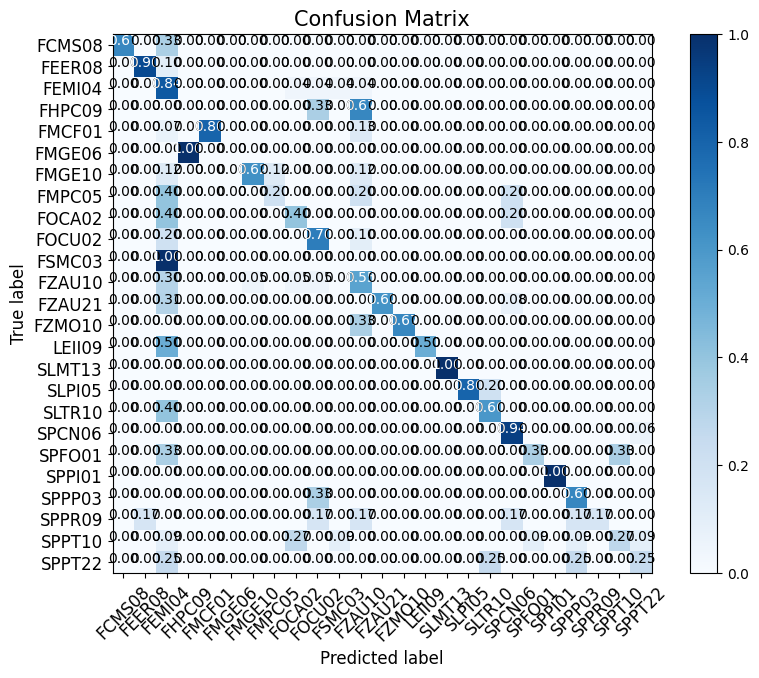

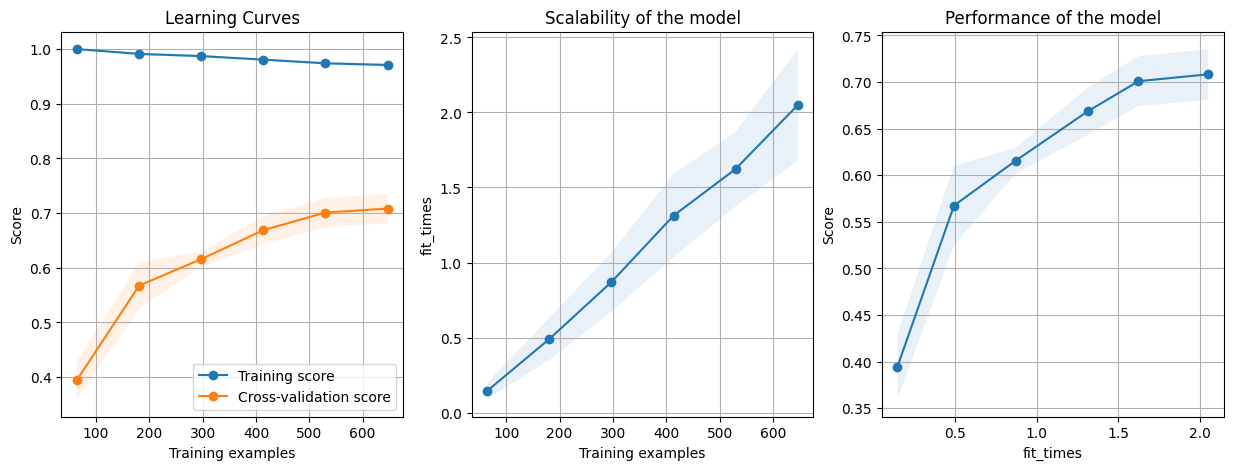

In [113]:
model_grid_transformer = {'solver': ['liblinear', 'saga'], 'C': [0.01, 1, 10], 'penalty': ['l1', 'l2']}
best_model_transformer, best_params_logreg_transformer = train_logistic_regression(X_train_transformer, y_train_trans, model_grid_transformer)
y_test_pred_transformer = best_model_transformer.predict(X_test_transformer)
evaluate_model_new(X_train_transformer, y_train_trans, y_test_trans, y_test_pred_transformer, best_model_transformer)

Slightly better performance with Embeddings

### 2.4) Synthetic Data. We create it with SMOTE.

Cojo los todas aquellas categorías que tiene entre 15 y 35 registros y hago que todos tengan 40 valores, creando los isntéticos que sean necesarios en cada caso

In [19]:
df_cleaned["MG Code"].value_counts().head(25)

MG Code
FEMI04    180
FZAU10     92
FOCU02     68
FZAU21     65
SPCN06     65
FOCA02     50
FMCF01     47
SPPT10     40
FEER08     37
SPPP03     36
SLMT13     35
SLTR10     31
SPPT22     27
FHPC09     25
SPPI01     24
SPFO01     23
FMGE10     22
SPPR09     21
SLPI05     21
FSMC03     20
FMGE06     19
FCMS08     17
LEII09     16
FZMO10     16
FMPC05     15
Name: count, dtype: int64

I take top 25 values and create synthetic data from minority ones, from the ones that have more than 15 until the ones that have less than 35.

In [32]:
# Step 1: Count occurrences of each MG Code
mg_counts = df_cleaned["MG Code"].value_counts()

# Step 2: Select MG Codes that appear between 15 and 35 times
resample_mg_codes = mg_counts[(mg_counts > 15) & (mg_counts < 35)].index.tolist()

# Step 3: Keep also MG Codes that have more than 35 occurrences
retain_mg_codes = mg_counts[mg_counts >= 35].index.tolist()

# Step 4: Filter dataset
df_resample = df_cleaned[df_cleaned["MG Code"].isin(resample_mg_codes)].reset_index(drop=True)
df_retain = df_cleaned[df_cleaned["MG Code"].isin(retain_mg_codes)].reset_index(drop=True)

# Step 5: Extract features and target
X_resamp = df_resample["TextoCombinado_clean"]
y_resamp = df_resample["MG Code"]

X_retain = df_retain["TextoCombinado_clean"]
y_retain = df_retain["MG Code"]

# Step 6: Split dataset
X_train_resamp, X_test_resamp, y_train_resamp, y_test_resamp = train_test_split(X_resamp, y_resamp, test_size=0.2, random_state=42, stratify=y_resamp)
X_train_retain, X_test_retain, y_train_retain, y_test_retain = train_test_split(X_retain, y_retain, test_size=0.2, random_state=42, stratify=y_retain)

# # Reset index to avoid KeyErrors
X_train_resamp = X_train_resamp.reset_index(drop=True)
y_train_resamp = y_train_resamp.reset_index(drop=True)
X_test_resamp = X_test_resamp.reset_index(drop=True)
y_test_resamp = y_test_resamp.reset_index(drop=True)

X_train_retain = X_train_retain.reset_index(drop=True)
y_train_retain = y_train_retain.reset_index(drop=True)
X_test_retain = X_test_retain.reset_index(drop=True)
y_test_retain = y_test_retain.reset_index(drop=True)

# Step 7: Get Transformer Embeddings
X_train_transformer_resamp = get_transformer_embeddings(model_transformer, X_train_resamp)
X_test_transformer_resamp = get_transformer_embeddings(model_transformer, X_test_resamp)

X_train_transformer_retain = get_transformer_embeddings(model_transformer, X_train_retain)
X_test_transformer_retain = get_transformer_embeddings(model_transformer, X_test_retain)

# Step 8: Define SMOTE sampling strategy
sampling_strategy = {code: 40 for code in resample_mg_codes if (y_train_resamp == code).sum() < 30}

# Step 9: Apply SMOTE only to resample MG Codes
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformer_resamp, y_train_resamp)

# Step 10: Combine resampled and retained data 
X_train_final = np.vstack((X_train_resampled, X_train_transformer_retain))
y_train_final = pd.concat([y_train_resampled, y_train_retain], ignore_index=True)

X_test_final = np.vstack((X_test_transformer_resamp, X_test_transformer_retain))
y_test_final = pd.concat([y_test_resamp, y_test_retain], ignore_index=True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches: 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


In [33]:
X_train_final.shape

(1092, 384)

In [34]:
X_test_final.shape

(200, 384)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
(accuracy, f1) are: (0.760000, 0.752739)

Classification Report:
               precision    recall  f1-score   support

      FCMS08       0.50      0.33      0.40         3
      FEER08       0.88      1.00      0.93         7
      FEMI04       0.74      0.89      0.81        36
      FHPC09       0.50      0.20      0.29         5
      FMCF01       0.89      0.89      0.89         9
      FMGE06       0.75      0.75      0.75         4
      FMGE10       1.00      0.40      0.57         5
      FOCA02       0.70      0.70      0.70        10
      FOCU02       0.92      0.79      0.85        14
      FSMC03       0.25      0.25      0.25         4
      FZAU10       0.62      0.68      0.65        19
      FZAU21       0.93      1.00      0.96        13
      FZMO10       0.50      0.67      0.57         3
      LEII09       0.60      1.00     

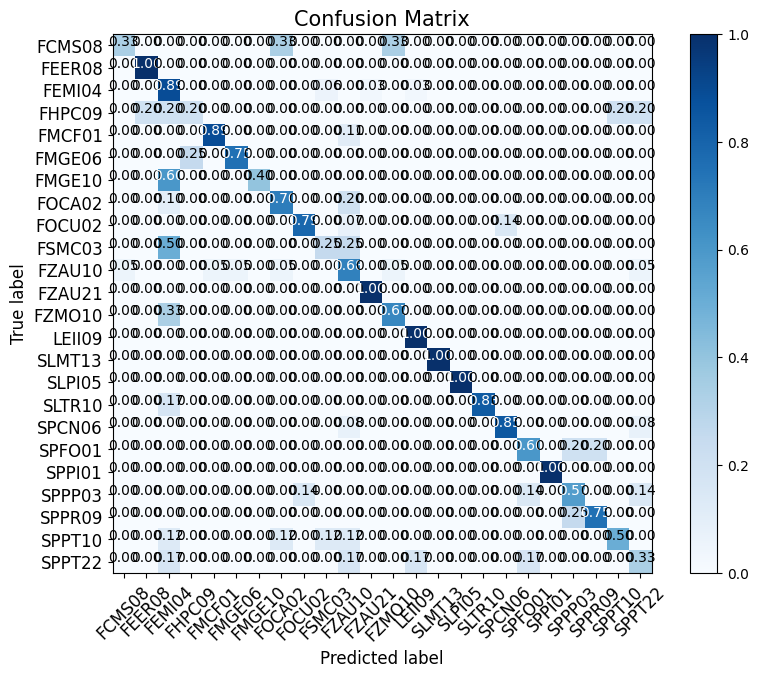

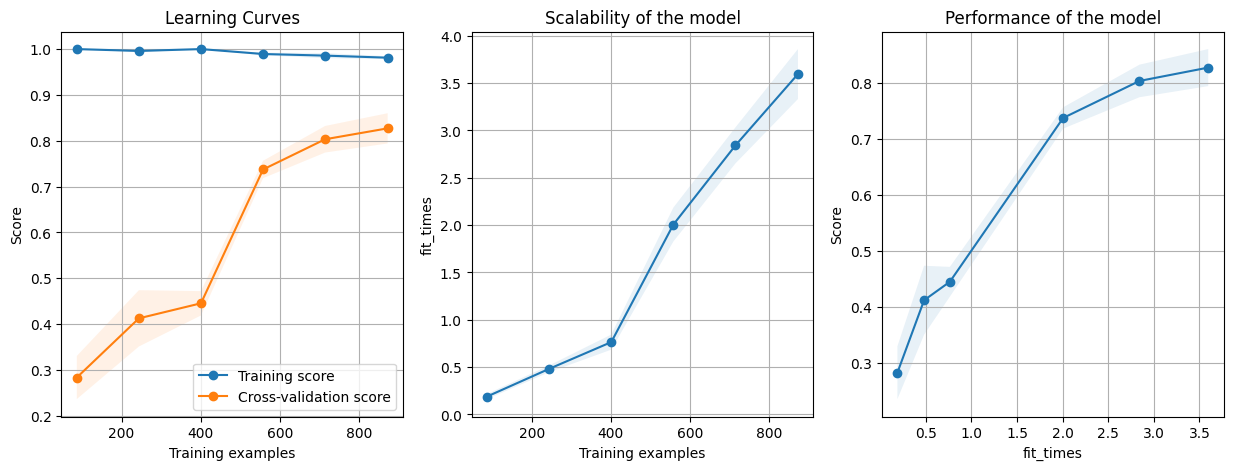

In [35]:
best_model_transformer_smote, best_params_logreg_transformer_smote = train_logistic_regression(X_train_final, y_train_final, model_grid)
y_test_final_pred = best_model_transformer_smote.predict(X_test_final)
evaluate_model_new(X_train_final, y_train_final, y_test_final, y_test_final_pred, best_model_transformer_smote)

No funciona del todo mal esta técnica, se podría incluso tratar de usar para todos los códigos, aunque crear 40 sintéticas para registros con un valor no tiene demasiado sentido, no tienes suficiente información inicial digamos.

Los datos sintéticos se crean con operaciones matemáticas a partir de los valores ya vectorizados dentro de esa consulta, buscando que sean similares pero obviamente no iguales. Los datos sintéticos sólo se usan en el entrenamiento, en el testeo se necesitan valores reales.